In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import daft
import seaborn 
import matplotlib.pyplot as plt


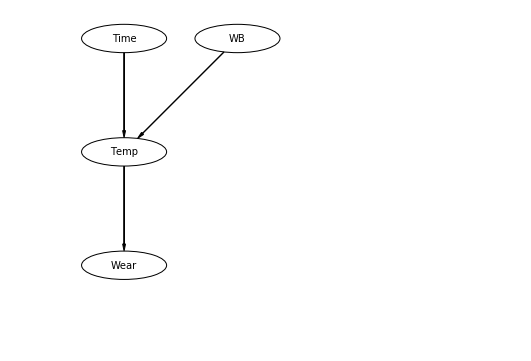

In [2]:
pgm = daft.PGM([9,6],origin=[1, 0.5])
pgm.add_node(daft.Node('Tme','Time',3,6,aspect=3))
pgm.add_node(daft.Node('WB','WB',5,6,aspect=3))
pgm.add_node(daft.Node('Temp','Temp',3,4,aspect=3))
pgm.add_node(daft.Node('Wear','Wear',3,2,aspect=3))
pgm.add_edge('Tme','Temp')
pgm.add_edge('WB','Temp')
pgm.add_edge('Temp','Wear')
pgm.render();


In [3]:
df = pd.read_csv('C:/Users/User/Desktop/Football/Bayes-master/Bayes-master/Temp.csv',sep=';')
Maxlife = 100000
intialTime=20

In [4]:
df.describe()

,Time,Temp,RunningTemp,Wear,Slot
count,4.0,4.000000,4.000000,4.000000,4.000000
mean,1.0,150.000000,193.000000,15.250000,2.500000
std,0.0,57.735027,43.150898,3.593976,1.290994
min,1.0,100.000000,155.000000,12.000000,1.000000
25%,1.0,100.000000,163.250000,12.750000,1.750000
50%,1.0,150.000000,183.000000,14.500000,2.500000
75%,1.0,200.000000,212.750000,17.000000,3.250000
max,1.0,200.000000,251.000000,20.000000,4.000000


In [5]:
temp_mean= df.Temp.mean()
temp_mean

150.0

In [6]:
df.skew()

Time           0.000000
Temp           0.000000
RunningTemp    1.003149
Wear           0.888584
Slot           0.000000
dtype: float64

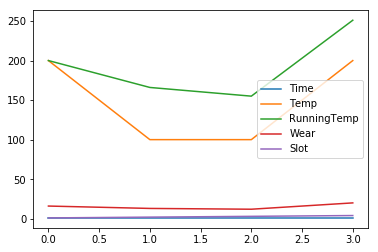

In [7]:
df.plot()
plt.show()

In [8]:
model = pm.Model();
with model:
    time = pm.Normal('time',intialTime)
    temp = pm.Normal('temp',mu=time)
    wear =pm.Normal('wear',mu=temp)
    trace = pm.sample(100000,tune=50000,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [wear, temp, time]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001880C600588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001880C804C18>]], dtype=object)

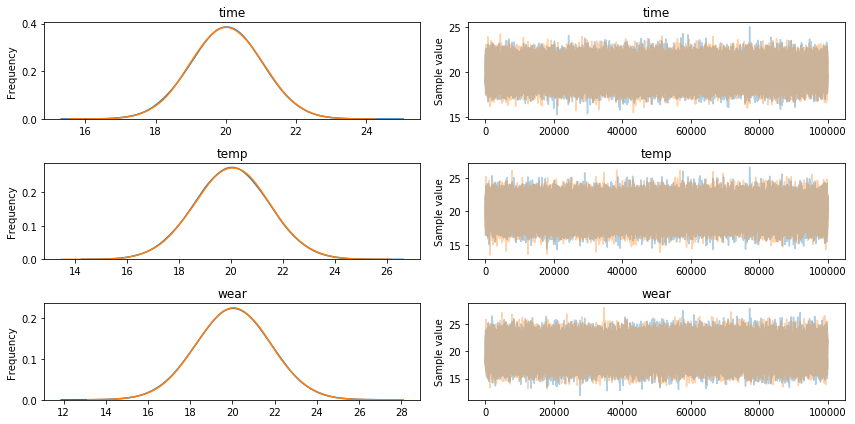

In [9]:
pm.traceplot(trace)

In [10]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
time,20.002995,1.000934,0.003135,18.037003,21.954570,82113.557031,1.000019
temp,20.001326,1.415957,0.004752,17.253988,22.819926,71151.027606,1.000031
wear,20.006033,1.736063,0.005501,16.588707,23.399449,76058.294348,1.000018


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001880CC86F28>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001880CD11080>], dtype=object)

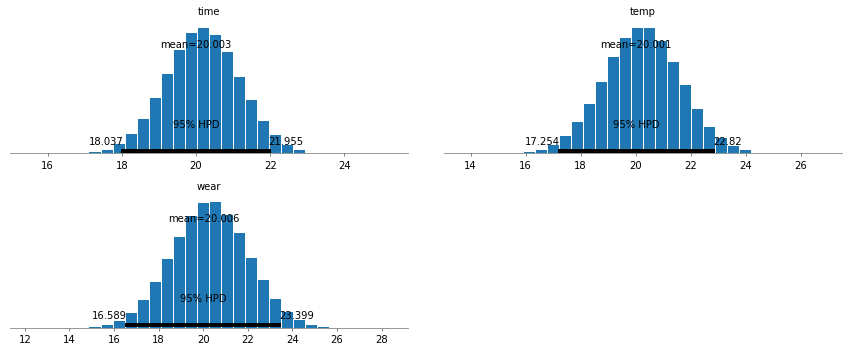

In [11]:
pm.plot_posterior(trace)

In [12]:
pred = pd.DataFrame({
    "Wear": trace["wear"][50000:],
    "Temp": trace["temp"][50000:],
    "Time": trace["time"][50000],
 
})


In [13]:
pred.Wear.mean()


20.005907835721683

In [14]:
pred.Temp.mean()
loopTime = pred.Time.mean()
loopWear = pred.Wear.mean()
loopTemp = pred.Temp.mean()

In [15]:
loopWear

20.005907835721683

In [16]:
loopTemp

20.00140283268433

In [17]:
loopTime

18.84496620809663

In [18]:

for i in range(0,len(df.Time)-1):    
    model2 = pm.Model();    
    with model2:        
        Time2 = pm.Normal('Time2',df.Time[i])
        Temp2 = pm.Normal('Temp2',mu=Time2+loopWear)
        wear2 = pm.Normal('wear2',mu=Temp2+loopWear)
        changedWear= pm.Normal('changedWear',mu=wear2-loopWear)
        trace2 = pm.sample(10000,tune=5000,progressbar=True)    
        globals()["predStep" + str(i)]= pd.DataFrame({
                    "Wear": trace2["wear2"][5000:],
                    "temp": trace2["Temp2"][5000:],
                    "time": trace2["Time2"][5000:],
                    "WearChanged": trace2["changedWear"][5000:]            
        })        
        globals()["predStep" + str(i)].to_csv('C:/Users/User/Desktop/Football/Bayes-master/Bayes-master/predStep_' + str(i+1)+'.csv', sep=';')
               
        loopTime = globals()["predStep" + str(i)].time.mean()
        loopWear = globals()["predStep" + str(i)].Wear.mean()        
        print(df.Time[i],' sec',round(((Maxlife-loopWear)/Maxlife)*100),'% life is left')
        
        #pm.traceplot(trace2.varnames)        
        #pm.plot_posterior(trace2)
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [changedWear, wear2, Temp2, Time2]


1  sec 100 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [changedWear, wear2, Temp2, Time2]


1  sec 100 % life is left


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [changedWear, wear2, Temp2, Time2]


1  sec 100 % life is left


In [ ]:
i=0
for i in range(0,len(df)-1):    
    fig, ax =plt.subplots(1,4)
    plt.figure(figsize=(840,840))
    seaborn.distplot(globals()["predStep" + str(i)].WearChanged,ax=ax[0])
    seaborn.distplot(globals()["predStep" + str(i)].Wear, ax=ax[1])
    seaborn.distplot(globals()["predStep" + str(i)].temp, ax=ax[2])
    seaborn.distplot(globals()["predStep" + str(i)].temp, ax=ax[3])
    fig.show()
    
    

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\User\Anaconda3\lib\site-packages\matplotlib\figure.py:459: User